# 3. **Model Training**

In [215]:
# Install dependencies
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [216]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn import FunctionSampler
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform, loguniform

In [ ]:
MODELS_DIR = os.path.join("..", "models")
RESULTS_DIR = os.path.join("..", "results", "training")
PLOTS_DIR = os.path.join(RESULTS_DIR, "imgs")
CSV_DIR = os.path.join(RESULTS_DIR, "csv")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(os.path.join(PLOTS_DIR, "confusion"), exist_ok=True)

Recover highly correlated features sets:

In [ ]:
df = pd.read_csv(os.path.join("..", "results", "EDA", "csv","correlated_groups.csv"))
correlated_feat_groups = df.groupby("group_id")["feature_name"].apply(list).tolist()

for i, group in enumerate(correlated_feat_groups, 1):
    print(f"Group {i}: {group}")

Group 1: ['MS_Sublimation', 'Ql']
Group 2: ['TSG', 'T_bottom']
Group 3: ['OLWR', 'TSS_meas', 'TSS_mod']
Group 4: ['ISWR', 'ISWR_dir', 'ISWR_h', 'OSWR']
Group 5: ['HS_meas', 'HS_mod', 'SWE', 'zS4', 'zSs']
Group 6: ['MS_water', 'S5']
Group 7: ['ccl_pwl', 'ccl_pwl_100', 'pwl_100', 'pwl_100_15', 'sk38_pwl', 'sk38_pwl_100', 'sn38_pwl_100', 'ssi_pwl', 'ssi_pwl_100']


## 3.1 **Pipelines factory**

Transformer for group-wise PCA:

In [219]:
def group_wise_pca_transformer(groups, n_components_per_group=None):
    transformers = []

    for i, group in enumerate(groups):
        n_components = 1 if n_components_per_group is None else n_components_per_group[i]
        transformers.append((
            f'pca_group_{i+1}',
            Pipeline([
                ('scale', StandardScaler()),
                ('pca', PCA(n_components=n_components, random_state=42))
            ]),
            group
        ))

    return ColumnTransformer(transformers, remainder='passthrough')

Models require several steps. To make the code more readable, we will create a pipeline factory that will allow us to create pipelines with different preprocessing steps.

In [ ]:
# Classifier and hyperparameter to be tuned
classifiers = {
    'RF': (
        RandomForestClassifier(
            n_jobs=-1, random_state=42
        ),
        {
            'classifier__bootstrap':      [True],
            'classifier__criterion':      ['gini'],
            'classifier__class_weight':   [None, 'balanced'],
            'classifier__max_depth':      randint(20, 51),      # integers [20, 50]
            'classifier__max_features':   ['log2'],
            'classifier__min_samples_leaf': randint(1, 51),     # [1, 50]
            'classifier__min_samples_split': randint(2, 51),    # [2, 50]
            'classifier__n_estimators':   randint(50, 1001)     # [50, 1000]
        }
    ),
    'XGB': (
        XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42
        ),
        {
            'classifier__learning_rate':    uniform(0.01, 0.19),  # [0.01, 0.20)
            'classifier__n_estimators':     randint(100, 501),    # [100, 500]
            'classifier__max_depth':        randint(3, 10),       # [3, 9]
            'classifier__min_child_weight': randint(1, 6),        # [1, 5]
            'classifier__gamma':            uniform(0.0, 0.3),    # [0.0, 0.30)
            'classifier__subsample':        uniform(0.6, 0.4),    # [0.6, 1.0)
            'classifier__colsample_bytree': uniform(0.6, 0.4),    # [0.6, 1.0)
            'classifier__reg_alpha':        uniform(0.0, 1.0),    # [0.0, 1.0)
            'classifier__reg_lambda':       uniform(1.0, 4.0)     # [1.0, 5.0)
        }
    ),
    'SVM': (
        SVC(
            probability=True,
            random_state=42
        ),
        {
            'classifier__kernel':       ['poly', 'linear'],
            'classifier__C':            loguniform(0.1, 100),        # continuous between 0.1 and 100
            'classifier__gamma':        ['scale', 'auto', 0.001, 0.01, 0.1],
            'classifier__degree':       randint(2, 5),               # [2, 4]
            'classifier__class_weight': [None, 'balanced']
        }
    )
}

# Oversampling methods and hyperparameters
oversamplers = {
    'SMOTE': (
        SMOTE(
            random_state=42),
        {
            'sampler__k_neighbors': [5],
            'sampler__sampling_strategy': ['auto']
        }
    ),
    'ROS': (
        RandomOverSampler(
            random_state=42),
        {
            'sampler__sampling_strategy': ['auto']
        }
    ),
    'NoR': (
        'passthrough',
        {
            # No oversampling
        }
    )
}

# Scalers
scalers = {
    'SS': StandardScaler(),
    'RS': RobustScaler(),
    'NoS': 'passthrough'
}

# Dimensionality reducers
reducers = {
    'SS': {
        'PCA99': PCA(n_components=0.99, random_state=42),
        'NoDR': 'passthrough'
    },
    'RS': {
        'PCA999': PCA(n_components=0.99, random_state=42),
        'NoDR': 'passthrough'
    },
    'NoS': {
        'L-PCA': group_wise_pca_transformer(
            correlated_feat_groups,
            n_components_per_group=[0.90] * len(correlated_feat_groups)
        ),
        'NoDR': 'passthrough'
    }
}

In [221]:
# Pipelines factory

pipelines = {}
param_grids = {}

for sampler_name, (oversampler, ovs_grid) in oversamplers.items():
    for scaler_name, scaler in scalers.items():
        for red_name, reducer in reducers[scaler_name].items():
            for clf_name, (clf, clf_grid) in classifiers.items():
                name = f"{clf_name}_{sampler_name}_{scaler_name}_{red_name}"
                # Pipeline
                pipelines[name] = ImbPipeline([
                    ('sampler', clone(oversampler) if oversampler != 'passthrough' else 'passthrough'),
                    ('scaler', clone(scaler) if scaler != 'passthrough' else 'passthrough'),
                    ('reducer', clone(reducer) if reducer != 'passthrough' else 'passthrough'),
                    ('classifier', clone(clf) if clf != 'passthrough' else 'passthrough')
                ])
                # Hyperparams grid
                param_grids[name] = {}
                param_grids[name].update(ovs_grid)
                param_grids[name].update(clf_grid)
                # Ajdust balance hyperparam
                if sampler_name == 'NoResampling' and clf_name in ['RF']:
                    param_grids[name]['classifier__class_weight'] = ['balanced']
                else:
                    param_grids[name]['classifier__class_weight'] = [None]

print(f"Number of pipelines: {len(pipelines)}")

Number of pipelines: 54


### 3.1.1 Adding the paper's baseline and optimized models 

In [222]:
# Baseline paper model: only classify
pipelines['Paper_Baseline'] = Pipeline([
    ('classifier', RandomForestClassifier(
        n_jobs=-1, random_state=42
    ))
])
# Hyperparameters
param_grids['Paper_Baseline'] = {
    'classifier__bootstrap': [True],
    'classifier__criterion': ['gini'],
    'classifier__class_weight': ['balanced'],
    'classifier__max_depth': [20],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [5],
    'classifier__min_samples_split': [5],
    'classifier__n_estimators': [1000]
}

In [223]:
# Selected features by the paper model
paper_features = [
    'HN72_24', 'HN24', 'HN24_7d', 'Pen_depth', 'min_ccl_pen',
    'MS_Snow', 'wind_trans24_3d', 'wind_trans24_7d', 'RH',
    'wind_trans24', 'TA', 'pAlbedo', 'Sn', 'S4', 'LWR_net',
    'Qs', 'ILWR', 'Qw', 'VW', 'ccl_pwl_100', 'ISWR', 'HS_mod',
    'zSn', 'TSS_mod', 'Qg0', 'ISWR_diff', 'VW_drift',
    'sn38_pwl_100', 'zSs', 'Ss'
]

# Optimized paper model: select only the specified features, then classify
pipelines['Paper_Optimized'] = Pipeline([
    ('selector', ColumnTransformer([
        ('feat_sel', 'passthrough', paper_features)
    ], remainder='drop')),
    ('classifier', RandomForestClassifier(
        n_jobs=-1, random_state=42
    ))
])
# Hyperparameters
param_grids['Paper_Optimized'] = {
    'classifier__bootstrap': [True],
    'classifier__criterion': ['gini'],
    'classifier__class_weight': ['balanced'],
    'classifier__max_depth': [40],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [6],
    'classifier__min_samples_split': [12],
    'classifier__n_estimators': [1000]
}

print(f"Number of pipelines: {len(pipelines)}")

Number of pipelines: 56


## 3.2 **Dataset Splits**

Initial dataset loading:

In [ ]:
RESOURCE_DIR = "resources"
CSV_FILE = "reduced_data_rf2_tidy.csv"
full_path = os.path.join('..', RESOURCE_DIR, CSV_FILE)

# Load the dataset
df = pd.read_csv(full_path, parse_dates=['datum'])
y = df['dangerLevel'].replace({5: 4})
y = pd.Series(LabelEncoder().fit_transform(y), name=y.name, index=y.index)
X = df.drop(columns=['dangerLevel', 'datum'])

In [ ]:
# Compute season ID (winter spanning Nov–Mar)
def season_id(dates: pd.Series) -> pd.Series:
    winter_year = dates.dt.year.where(dates.dt.month >= 11, dates.dt.year - 1)
    return winter_year

# Assign groups
groups = season_id(df['datum'])
uniq_seasons = np.sort(groups.unique())

### 3.2.1 Outer Holdout Split

Before any screening or hyperparameter search, we reserve the last 3 seasons as a final out-of-time hold-out, to guarantee almost a 3:1 ratio between train and test sets sizes. 
All subsequent CV and model tuning will use only the earlier seasons.


In [226]:
OUTER_HOLD = 3
train_seasons = uniq_seasons[:-OUTER_HOLD]
test_seasons = uniq_seasons[-OUTER_HOLD:]
print(f"Train seasons: {train_seasons}")
print(f"Test seasons: {test_seasons}")

# Indices for train/test split
train_idx = np.where(groups.isin(train_seasons))[0]
test_idx = np.where(groups.isin(test_seasons))[0]
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test,  y_test  = X.iloc[test_idx],  y.iloc[test_idx]

print(f"Ratio: {len(X_train)/len(X_test):.2f}:1")

Train seasons: [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]
Test seasons: [2017 2018 2019]
Ratio: 3.01:1


### 3.2.2 Inner CV Split

As inner CV Splits, we'll use **expanding-window cross-validation** to:
- Mimic the *real classification scenario*: each fold trains on all available past data.
- **Prevent data leakage** by ensuring validation is always “in the future”.
- Provide consistent splits for *baseline screening*, *hyperparameter tuning* and *statistical model comparison*.

In [227]:
def get_expanding_splits(groups: pd.Series,
                          train_seasons: np.ndarray,
                          n_folds: int):
    """
    Generate expanding-window CV splits over seasons.

    Parameters:
    - groups: pd.Series of season IDs aligned with df index.
    - train_seasons: sorted array of seasons to use for CV.
    - n_folds: number of expanding folds.

    Returns:
    - List of (train_idx, val_idx) tuples for CV.
    """
    initial = len(train_seasons) - n_folds
    splits = []
    for i in range(n_folds):
        # Grow training window by one season per fold
        train_slice = train_seasons[: initial + i]
        val_season = train_seasons[initial + i]
        train_idx_i = np.where(groups.isin(train_slice))[0]
        val_idx_i   = np.where(groups == val_season)[0]
        splits.append((train_idx_i, val_idx_i))
    return splits

## 3.3 **Pipeline Screening** (Baseline Performance)

Before launching an expensive hyperparameter search, we first run a quick “sanity check” on each candidate pipeline using default settings. This lets us:

- **Identify and discard** pipelines that perform poorly out-of-the-box  
- **Focus compute budget** on the most promising few  

We’ll perform a 5-fold time-series-aware cross-validation and record the mean f1_macro for each pipeline.

In [ ]:
from sklearn.preprocessing import LabelEncoder

N_SCREEN = 5
screen_splits = get_expanding_splits(groups, train_seasons, N_SCREEN)

baseline_records = []
for name, pipe in tqdm(pipelines.items(), desc="Screening pipelines", unit="pipeline"):
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=screen_splits,
        scoring='f1_macro',
        n_jobs=-1
    )
    baseline_records.append({
        'pipeline': name,
        'mean_f1': np.mean(scores),
        'std_f1': np.std(scores),
        'median_f1': np.median(scores)
    })

# Create DataFrame of baseline results
baseline_df = pd.DataFrame(baseline_records)
# Sort by mean F1 descending
baseline_df.sort_values(by='mean_f1', ascending=False, inplace=True)
# Save full results
baseline_df.to_csv(os.path.join(CSV_DIR, 'baseline_screening_all.csv'), index=False)
baseline_df

Screening pipelines: 100%|██████████| 56/56 [1:17:29<00:00, 83.02s/pipeline] 


,pipeline,mean_f1,std_f1,median_f1
30,RF_ROS_NoS_L-PCA,0.593494,0.037301,0.588568
27,RF_ROS_RS_NoDR,0.593407,0.038426,0.598226
33,RF_ROS_NoS_NoDR,0.593227,0.038737,0.596485
21,RF_ROS_SS_NoDR,0.593141,0.038265,0.597858
46,XGB_NoR_RS_NoDR,0.589518,0.038387,0.603063
40,XGB_NoR_SS_NoDR,0.588900,0.040995,0.603063
49,XGB_NoR_NoS_L-PCA,0.588820,0.036834,0.603877
12,RF_SMOTE_NoS_L-PCA,0.586731,0.033330,0.595546
28,XGB_ROS_RS_NoDR,0.586413,0.043846,0.593609
22,XGB_ROS_SS_NoDR,0.585642,0.040484,0.593371


## 3.4 **Hyperparameters tuning**

Based on the initial expanding-window screening results, we select k = 9 pipelines (plus the paper's one) from the most promising ones for a more exhaustive hyperparameter search, aiming to balance performance margin, algorithmic diversity, and computational budget.

This selection (9 pipelines x N_ITER x N_SPLITS) yields ≈ 9 x 100 x 5 = 4500 inner-CV fits,
a manageable budget that still explores the most promising model and preprocessing combinations.


In [230]:
candidates = {name: pipelines[name] for name in [
    'RF_ROS_NoS_L-PCA',
    'RF_ROS_RS_NoDR',
    'RF_ROS_SS_NoDR',
    'RF_SMOTE_NoS_L-PCA',
    'RF_NoR_NoS_NoDR',

    'XGB_NoR_RS_NoDR',
    'XGB_NoR_NoS_L-PCA',
    'XGB_ROS_RS_NoDR',
    
    'SVM_NoR_SS_PCA99',

    'Paper_Optimized'
]}

Now, we perform hyperparameter optimization on the previously *top-k* pipelines. We use **RandomizedSearchCV** with **expanding-window cross-validation** to search over defined parameter distributions for each pipeline, optimizing for *macro F1*.

In [231]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
import pandas as pd

N_ITER = 100
N_SPLITS = 5
inner_splits = get_expanding_splits(groups, train_seasons, N_SPLITS)
results = []

# Loop through pipelines for tuning
for name, pipe in candidates.items():
    grid = param_grids[name]
    print(f"Tuning pipeline: {name}")

    # RandomizedSearchCV on training data only
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=grid,
        cv=inner_splits,            # expanding-window CV on X_train
        scoring="f1_macro",       # optimize f1_macro
        n_iter=N_ITER,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train, y_train)

    # Collect tuning summary
    results.append({
        "pipeline": name,
        "best_cv_score": search.best_score_,
        "best_params": search.best_params_
    })
    print(f" - Best CV score: {search.best_score_:.4f}")
    print(f" - Best parameters: {search.best_params_}\n")

# Save tuning summary
tuning_df = pd.DataFrame(results)
tuning_df.to_csv(os.path.join(CSV_DIR, 'tuning_summary.csv'), index=False)
print("Saved tuning summary for all pipelines.")

Tuning pipeline: RF_ROS_NoS_L-PCA
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 - Best CV score: 0.5980

 - Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 687, 'sampler__sampling_strategy': 'auto'}

Tuning pipeline: RF_ROS_RS_NoDR
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 - Best CV score: 0.5968

 - Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 687, 'sampler__sampling_strategy': 'auto'}

Tuning pipeline: RF_ROS_SS_NoDR
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 - Best CV score: 0.5968

 - Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 687, 'sampler__sampling_strategy': 'auto'}

Tuning pipeline: RF_SMOTE_NoS_L-PCA
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 - Best CV score: 0.5851

 - Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 40, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 21, 'classifier__n_estimators': 141, 'sampler__k_neighbors': 5, 'sampler__sampling_strategy': 'auto'}

Tuning pipeline: RF_NoR_NoS_NoDR
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 - Best CV score: 0.5754

 - Best parameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 37, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 26, 'classifier__n_estimators': 365}

Tuning pipeline: XGB_NoR_RS_NoDR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
 - Best CV score: 0.5979

 - Best parameters: {'classifier__class_weight': None, 'classifier__colsample_bytree': np.float64(0.6281664523398175), 'classifier__gamma': np.float64(0.06267561528460805), 'classifier__learning_rate': np.float64(0.13751726819656962), 'classifier__max_depth': 9, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 226, 'classifier__reg_alpha': np.float64(0.5183296523637367), 'classifier__reg_lambda': np.float64(4.509492287711822), 'classifier__subsample': np.float64(0.8963074471016818)}

Tuning pipeline: XGB_NoR_NoS_L-PCA
Fitting 5 folds for each

c:\Users\Utente\OneDrive - University of Pisa\AIDE\1° anno\Data Mining and Machine Learning\Project\avalanche-forecasting\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


 - Best CV score: 0.5890

 - Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 'log2', 'classifier__max_depth': 40, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}

Saved tuning summary for all pipelines.


In [240]:
baseline_df = pd.read_csv(os.path.join(CSV_DIR, 'baseline_screening_all.csv'))
tuning_df = pd.read_csv(os.path.join(CSV_DIR, 'tuning_summary.csv'))
merged_results = []
for r in results:
    name = r['pipeline']
    best_score = r['best_cv_score']
    default_mean = baseline_df.loc[baseline_df['pipeline']==name, 'mean_f1'].values[0]
    if default_mean > best_score:
        # Use default classifier params
        clf = pipelines[name].named_steps['classifier']
        default_params = {f'classifier__{k}': v for k, v in clf.get_params().items()}
        merged_results.append({
            'pipeline': name,
            'best_cv_score': default_mean,
            'best_params': default_params,
            'used_default': True
        })
    else:
        merged_results.append({
            'pipeline': name,
            'best_cv_score': best_score,
            'best_params': r['best_params'],
            'used_default': False
        })
merged_df = pd.DataFrame(merged_results)
merged_df.to_csv(os.path.join(CSV_DIR, 'merged_tuning_summary.csv'), index=False)
merged_df

,pipeline,best_cv_score,best_params,used_default
0,RF_ROS_NoS_L-PCA,0.598049,"{'classifier__bootstrap': True, 'classifier__c...",False
1,RF_ROS_RS_NoDR,0.596792,"{'classifier__bootstrap': True, 'classifier__c...",False
2,RF_ROS_SS_NoDR,0.596768,"{'classifier__bootstrap': True, 'classifier__c...",False
3,RF_SMOTE_NoS_L-PCA,0.586731,"{'classifier__bootstrap': True, 'classifier__c...",True
4,RF_NoR_NoS_NoDR,0.575359,"{'classifier__bootstrap': True, 'classifier__c...",False
5,XGB_NoR_RS_NoDR,0.597877,"{'classifier__class_weight': None, 'classifier...",False
6,XGB_NoR_NoS_L-PCA,0.600498,"{'classifier__class_weight': None, 'classifier...",False
7,XGB_ROS_RS_NoDR,0.597030,"{'classifier__class_weight': None, 'classifier...",False
8,SVM_NoR_SS_PCA99,0.591932,"{'classifier__C': 3.002984436915129, 'classifi...",False
9,Paper_Optimized,0.589039,"{'classifier__n_estimators': 1000, 'classifier...",False


# 3.5 **Model Selection**

In [245]:
from sklearn.metrics import f1_score
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

### 3.5.1 Collecting CV scores

In [ ]:
N_FOLDS_OUT = 15
outer_splits = get_expanding_splits(groups, train_seasons, N_FOLDS_OUT)

# Collect CV scores via cross_val_score
scores_dict = {}
for r in tqdm(merged_results, desc="Collecting CV scores", unit="pipeline"):
    name = r['pipeline']
    pipe = pipelines[name]
    pipe.set_params(**r['best_params'])
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=outer_splits,
        scoring='f1_macro',
        n_jobs=-1
    )
    scores_dict[name] = scores

# Results summary
scores_df = pd.DataFrame(scores_dict)
scores_df.to_csv(os.path.join(CSV_DIR, 'comparison_scores.csv'))
summary_df = pd.DataFrame({
    'mean_f1': scores_df.mean(),
    'std_f1': scores_df.std(),
    'median_f1': scores_df.median()
})
df_sorted = summary_df.sort_values(by='median_f1', ascending=False)
df_sorted

,mean_f1,std_f1,median_f1
Paper_Optimized,0.619969,0.054329,0.619131
XGB_NoR_NoS_L-PCA,0.605637,0.052769,0.616364
RF_ROS_NoS_L-PCA,0.621309,0.049262,0.615932
RF_SMOTE_NoS_L-PCA,0.611372,0.048239,0.614601
XGB_ROS_RS_NoDR,0.614065,0.050430,0.613761
XGB_NoR_RS_NoDR,0.613836,0.056496,0.611767
RF_ROS_RS_NoDR,0.614805,0.044848,0.604449
RF_ROS_SS_NoDR,0.614866,0.045232,0.604449
SVM_NoR_SS_PCA99,0.598283,0.049327,0.596988
RF_NoR_NoS_NoDR,0.598826,0.048139,0.596429


### 3.5.2 Statistical comparison

In [266]:
ALPHA = 0.05
# Friedman test
stat, p = friedmanchisquare(*[scores_df[col] for col in scores_df.columns])
print(f"Friedman test statistic: {stat:.3f}, p-value: {p:.4f}")
if p < ALPHA:
    print("Significant differences detected: proceeding with Nemenyi post-hoc test.")
    # Post-hoc Nemenyi
    nemenyi_matrix = sp.posthoc_nemenyi_friedman(scores_df.values)
    nemenyi_df = pd.DataFrame(nemenyi_matrix).set_index(nemenyi_df.index).set_axis(nemenyi_df.columns,axis=1)
    # A model X is a winner if no other model Y is significantly better according to Nemenyi
    winners = []
    for model in nemenyi_df.index:
        better = False
        for other in nemenyi_df.columns:
            if other != model and nemenyi_df.loc[other, model] < ALPHA:
                better = True
                break
        if not better:
            winners.append(model)
else:
    winners = [model for model in scores_df.columns]
    print("No significant differences found by Friedman test; skipping post-hoc analysis.")
print(f"Best models:")
best_models = df_sorted[df_sorted.index.isin(winners)]
best_models.to_csv(os.path.join(CSV_DIR, 'best_models.csv'))
best_models

Friedman test statistic: 20.327, p-value: 0.0160
Significant differences detected: proceeding with Nemenyi post-hoc test.
Best models:


,mean_f1,std_f1,median_f1
Paper_Optimized,0.619969,0.054329,0.619131
XGB_NoR_NoS_L-PCA,0.605637,0.052769,0.616364
RF_SMOTE_NoS_L-PCA,0.611372,0.048239,0.614601
XGB_ROS_RS_NoDR,0.614065,0.050430,0.613761
XGB_NoR_RS_NoDR,0.613836,0.056496,0.611767
RF_ROS_RS_NoDR,0.614805,0.044848,0.604449
RF_ROS_SS_NoDR,0.614866,0.045232,0.604449


### 3.5.3 Final Evaluation using Hold-out Set

Evaluating models: 100%|██████████| 7/7 [02:23<00:00, 20.56s/model]


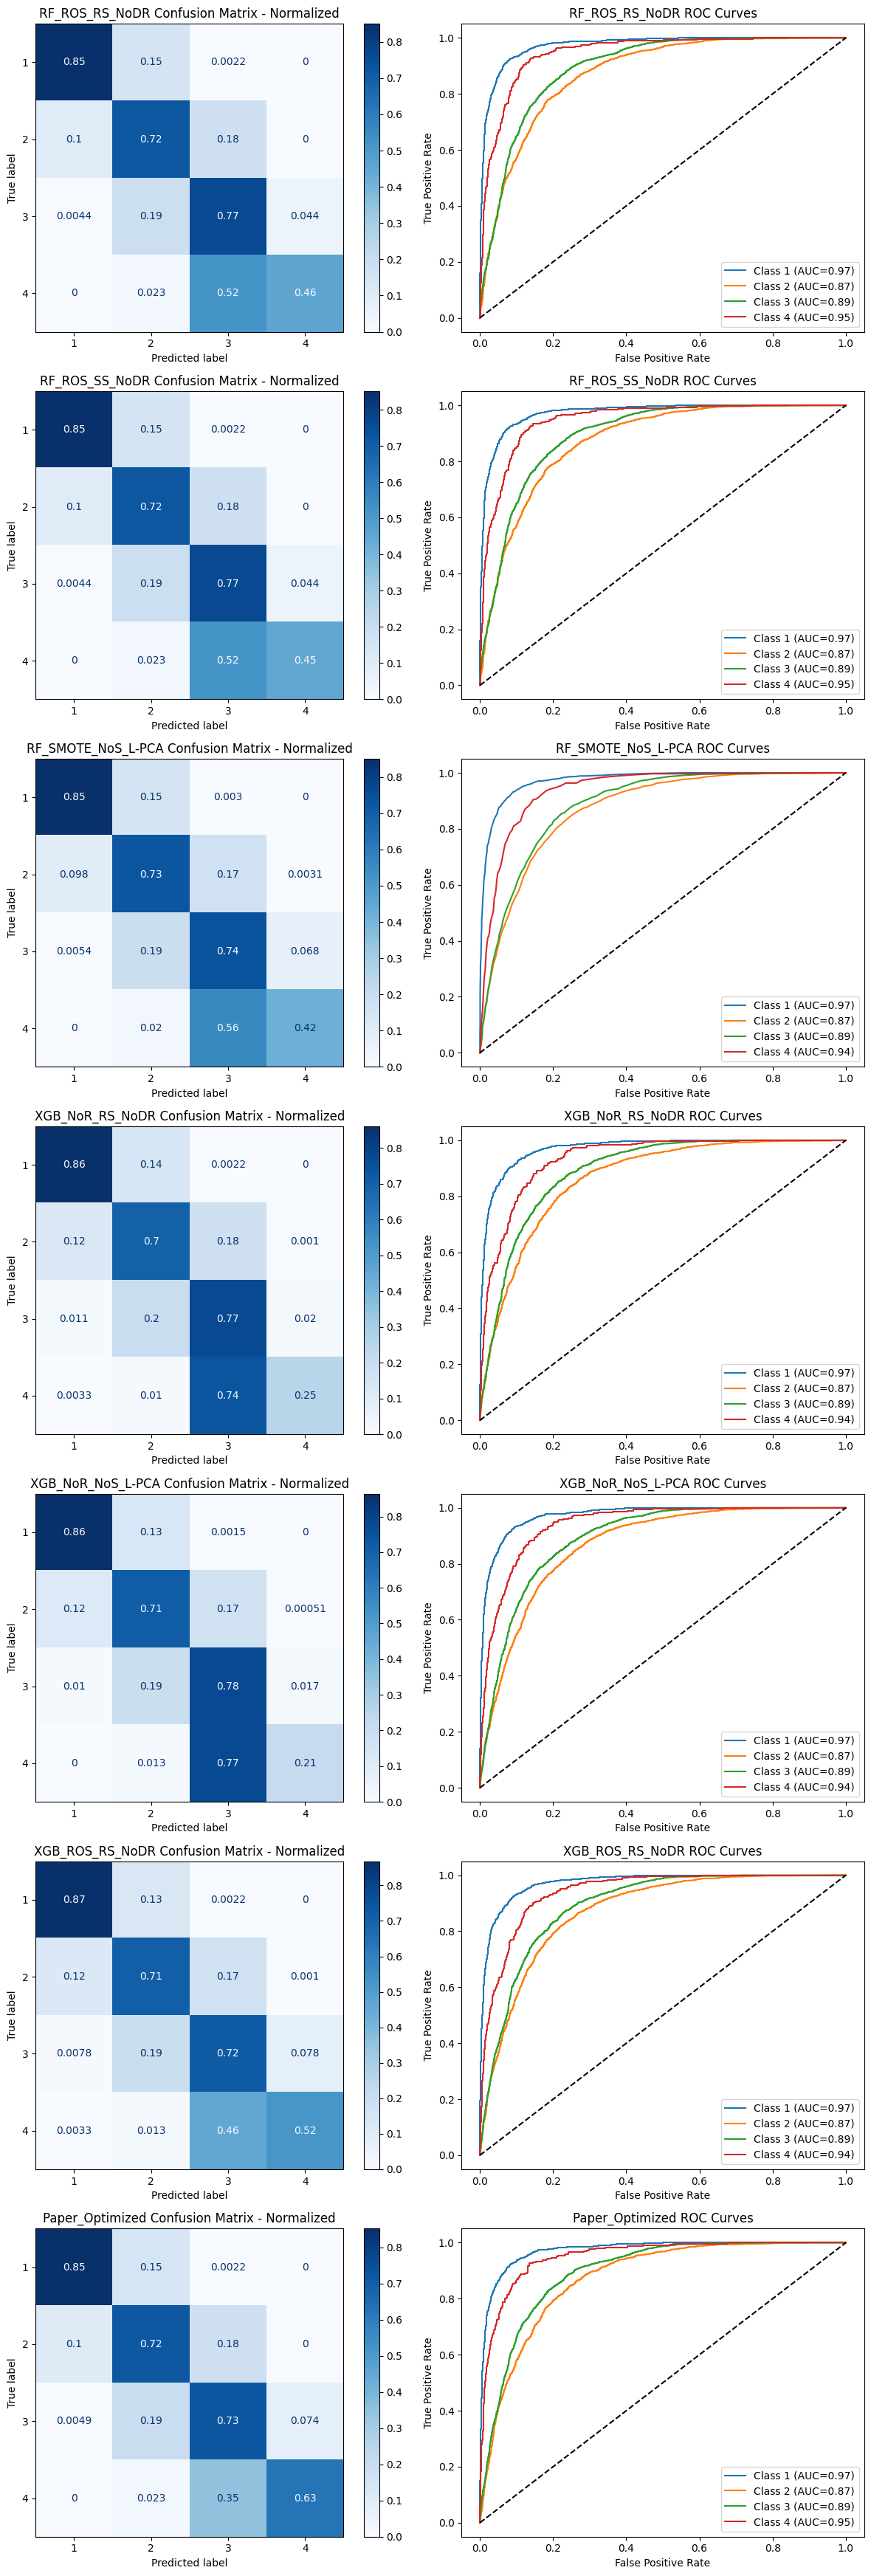

Evaluation results:


,accuracy,f1_macro,balanced_accuracy,mcc
RF_ROS_RS_NoDR,0.754209,0.710624,0.698313,0.641582
RF_ROS_SS_NoDR,0.754563,0.710500,0.697977,0.642067
RF_SMOTE_NoS_L-PCA,0.742867,0.686936,0.682776,0.626233
XGB_NoR_RS_NoDR,0.739677,0.661388,0.645076,0.618530
XGB_NoR_NoS_L-PCA,0.745880,0.657204,0.641983,0.627126
XGB_ROS_RS_NoDR,0.742158,0.700881,0.706312,0.627547
Paper_Optimized,0.748361,0.722989,0.731236,0.636519


In [327]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

# Evaluate each winning model on the hold-out set
selected_models = winners
n_models = len(selected_models)
fig, axes = plt.subplots(n_models, 2, figsize=(12, 5 * n_models))

# Binarize true labels for ROC curves
classes = np.unique(y_test)
y_bin = label_binarize(y_test, classes=classes)

evaluation_df = {name: {} for name in selected_models}
for idx, name in enumerate(tqdm(selected_models, desc="Evaluating models", unit="model")):
    ax_cm_norm = axes[idx, 0] if n_models > 1 else axes[0]
    ax_roc = axes[idx, 1] if n_models > 1 else axes[1]
    # Prepare and fit pipeline with final parameters
    pipe = pipelines[name]
    params = next(r['best_params'] for r in merged_results if r['pipeline'] == name)
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # Some classifiers may not implement predict_proba (e.g. SVC with default), use decision_function if needed
    try:
        y_prob = pipe.predict_proba(X_test)
    except AttributeError:
        y_prob = pipe.decision_function(X_test)
        # If decision_function yields shape (n_samples,) convert to 2-class
        if y_prob.ndim == 1:
            y_prob = np.vstack([1 - y_prob, y_prob]).T

    # Compute metrics
    evaluation_df[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'mcc': matthews_corrcoef(y_test, y_pred)
    }

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=[1, 2, 3, 4],
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax_cm_norm
    )
    ax_cm_norm.set_title(f"{name} Confusion Matrix - Normalized")

    # Plot ROC curves (one-vs-rest)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f"Class {cls + 1} (AUC={roc_auc:.2f})")
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f"{name} ROC Curves")
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc='lower right')

# Figures
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "best_models_evaluation.png"))
plt.show()

# Evaluation results
evaluation_df = pd.DataFrame(evaluation_df).T
evaluation_df.to_csv(os.path.join(CSV_DIR, 'best_models_evaluation.csv'))
print("Evaluation results:")
evaluation_df

### 3.5.4 Selected models

We chose **`XGB_ROS_RS_NoDR`** as our primary candidate because, among all pipelines rigorously tuned under a leakage-safe, expanding-window CV scheme, it is one of only two models (the other being the paper’s own *Paper_Optimized*) to achieve **over 50 % recall on the critical class 4** in the hold-out confusion matrix. Unlike the paper’s reported parameters—which may have benefited from temporal data leakage—our *XGB_ROS_RS_NoDR* configuration was derived entirely within a strictly out-of-time validation framework, ensuring its class-4 performance is both robust and unbiased.

To maintain flexibility, we also preserve `RF_ROS_SS_NoDR` and the original `Paper_Optimized` pipelines. 

In [ ]:
# Selected final models based on evaluation
final_models = [
    'XGB_ROS_RS_NoDR',
    'RF_ROS_SS_NoDR',
    'Paper_Optimized'
]

Now we retrain the selected models on the entire dataset, including the hold-out set, to maximize its performance before saving them:

In [329]:
import joblib

# Save the best models
for model_name in tqdm(final_models, desc="Saving final models", unit="model"):
    best_params = next(r['best_params'] for r in merged_results if r['pipeline'] == model_name)
    best_model = pipelines[model_name]
    best_model.set_params(**best_params)
    best_model.fit(X, y)
    joblib.dump(best_model, os.path.join(MODELS_DIR, f"{model_name}.pkl"))

Saving final models: 100%|██████████| 3/3 [01:54<00:00, 38.07s/model]


### 3.5.5 Some considerations

For the final selected model, we show some additional plots:

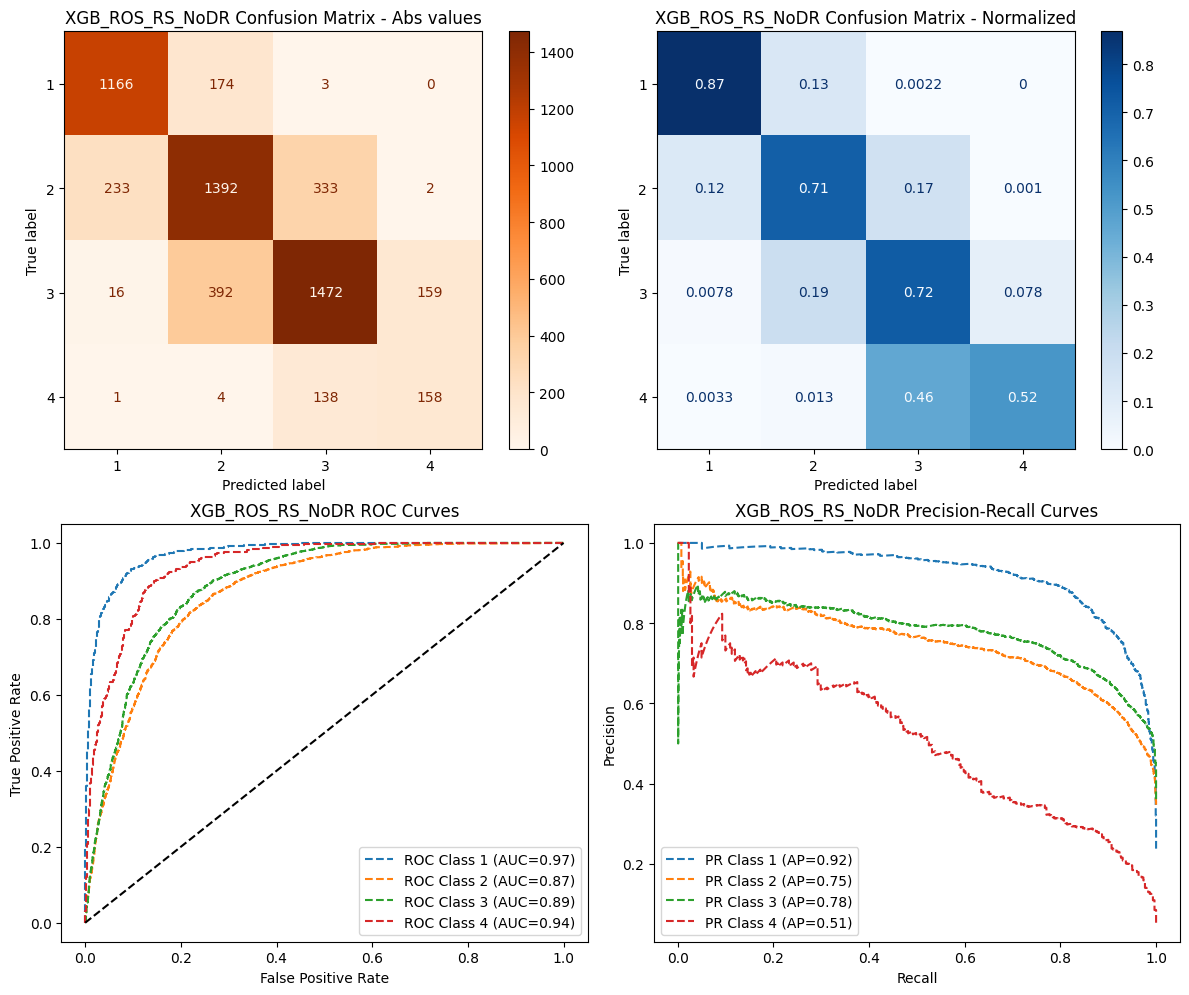

In [355]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
classes = np.unique(y_test)
y_bin = label_binarize(y_test, classes=classes)

model_name = final_models[0]
model = clone(pipelines[model_name])
model.set_params(**next(r['best_params'] for r in merged_results if r['pipeline'] == model_name))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Some classifiers may not implement predict_proba (e.g. SVC with default), use decision_function if needed
try:
    y_prob = model.predict_proba(X_test)
except AttributeError:
    y_prob = model.decision_function(X_test)
    # If decision_function yields shape (n_samples,) convert to 2-class
    if y_prob.ndim == 1:
        y_prob = np.vstack([1 - y_prob, y_prob]).T

# Confusion matrix (absolute values)
ax_cm = axes[0, 0]
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[1, 2, 3, 4],
    cmap=plt.cm.Oranges,
    ax=ax_cm
)
ax_cm.set_title(f"{model_name} Confusion Matrix - Abs values")

# Confusion matrix (Normalized)
ax_cm_norm = axes[0, 1]
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[1, 2, 3, 4],
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax_cm_norm
)
ax_cm_norm.set_title(f"{model_name} Confusion Matrix - Normalized")

# ROC curves (one-vs-rest)
ax_roc = axes[1, 0]
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, linestyle='--', label=f"ROC Class {cls + 1} (AUC={roc_auc:.2f})")
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_title(f"{model_name} ROC Curves")
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend(loc='lower right')

# Precision-Recall curves (one-vs-rest)
ax_pr = axes[1, 1]
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_bin[:, i], y_prob[:, i])
    ax_pr.plot(recall, precision, linestyle='--', label=f"PR Class {cls + 1} (AP={ap:.2f})")
ax_pr.set_title(f"{model_name} Precision-Recall Curves")
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.legend(loc='lower left')

# Figures
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "best_model_focus.png"))
plt.show()

Despite a strong ROC-AUC of 0.94 for class 4—indicating that the model can almost always rank true-4 events above others—the default argmax rule only recovers about 52 % of those highest-danger days, with nearly half misclassified as class 3.  The precision-recall curve (PR-AUC = 0.51) further shows that pushing recall beyond 0.70 drives precision below 0.30, creating an unmanageable number of false alarms.  A validation-based threshold sweep suggests that lowering the class-4 cutoff to around 0.37 raises recall to roughly 62 % at the cost of a 10 % false-alarm rate—but any such threshold must be chosen on validation (e.g. via nested CV), not by inspecting the test-set confusion matrix, to ensure an unbiased final evaluation.

To investigate how our decision boundary affects class 4 detection, we ran **three exploratory threshold sweeps**, each maximizing F1-score, precision, and recall respectively:

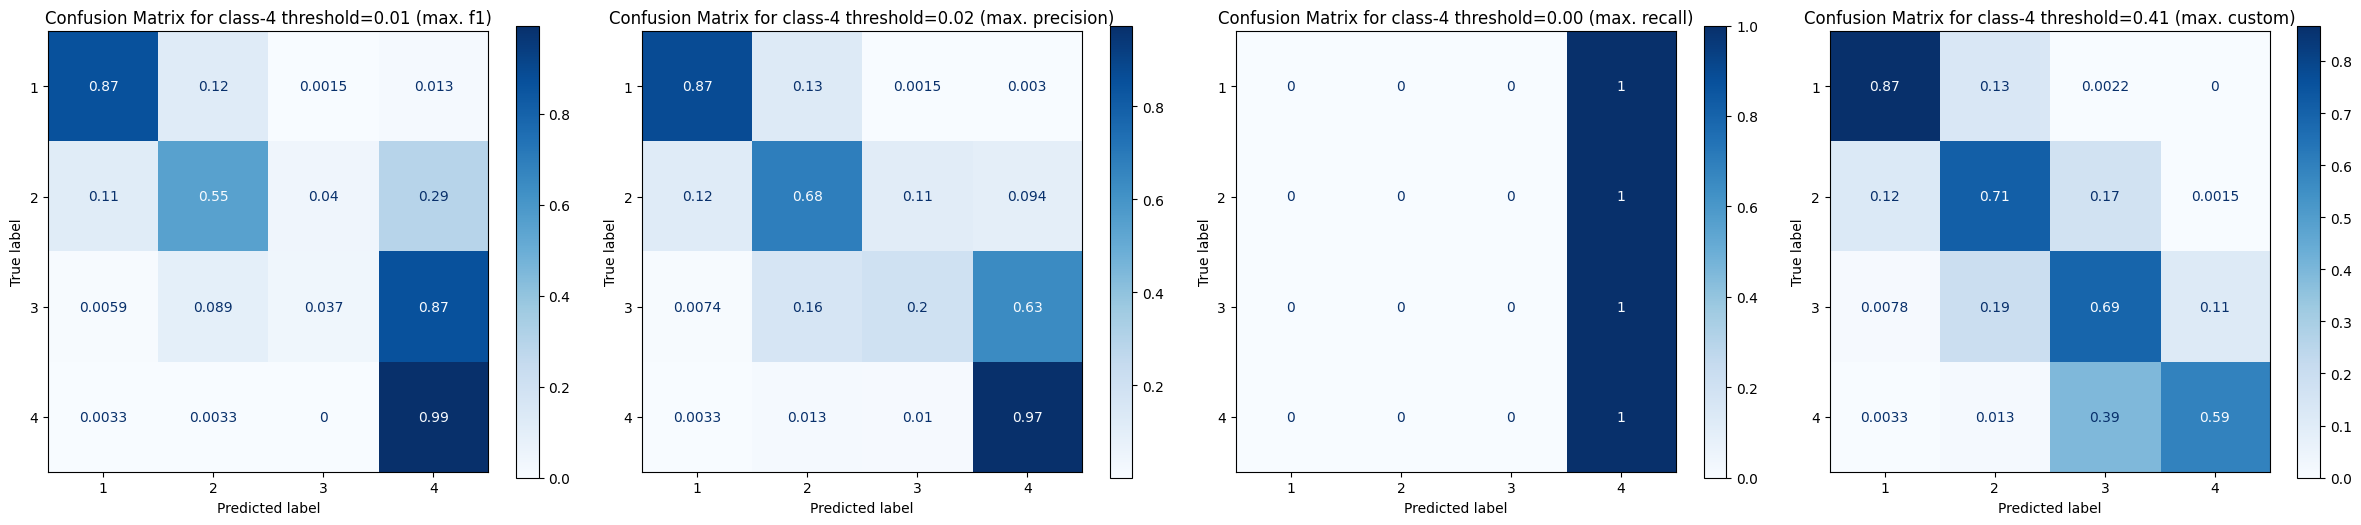

Best thresholds for class 4:


,threshold,precision,recall,f1
f1,0.005765,0.670082,0.845898,0.747795
precision,0.024079,0.736142,0.613452,0.669220
recall,0.000053,0.357937,1.000000,0.527177
custom,0.410000,NaN,NaN,NaN


In [358]:
# Get predicted probabilities for class 4
y_score = model.predict_proba(X_hold)[:, -1]  # assumes class4 is last
# True binary labels for class 4 vs rest
y_true4 = (y_hold == classes[-1]).astype(int)

# Compute precision-recall curve
prec, rec, thresh = precision_recall_curve(y_true4, y_score)
pr_auc = calc_auc(rec, prec)

# Compute class-4 F1 at each PR threshold
f1_records = []
for p, r, t in zip(prec, rec, thresh):
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    f1_records.append({'threshold': t, 'precision': p, 'recall': r, 'f1': f1})
f1_df = pd.DataFrame(f1_records)

# Best thresholds for F1, precision, and recall
CUSTOM_THRESHOLD = 0.41  # Custom threshold for class 4
best_thresholds = {
    'f1': {
        'threshold': f1_df.loc[f1_df['f1'].idxmax(), 'threshold'],
        'precision': f1_df.loc[f1_df['f1'].idxmax(), 'precision'],
        'recall': f1_df.loc[f1_df['f1'].idxmax(), 'recall'],
        'f1': f1_df.loc[f1_df['f1'].idxmax(), 'f1']
    },
    'precision': {
        'threshold': f1_df.loc[f1_df['precision'].idxmax(), 'threshold'],
        'precision': f1_df.loc[f1_df['precision'].idxmax(), 'precision'],
        'recall': f1_df.loc[f1_df['precision'].idxmax(), 'recall'],
        'f1': f1_df.loc[f1_df['precision'].idxmax(), 'f1']
    },
    'recall': {
        'threshold': f1_df.loc[f1_df['recall'].idxmax(), 'threshold'],
        'precision': f1_df.loc[f1_df['recall'].idxmax(), 'precision'],
        'recall': f1_df.loc[f1_df['recall'].idxmax(), 'recall'],
        'f1': f1_df.loc[f1_df['recall'].idxmax(), 'f1']
    },
    'custom': {
        'threshold': CUSTOM_THRESHOLD
    }
}
best_thresholds_df = pd.DataFrame(best_thresholds).T
best_thresholds_df.to_csv(os.path.join(CSV_DIR, 'best_thresholds.csv'))

# Plotting confusion matrices for the defined threshold
probs = model.predict_proba(X_test)
class_labels = classes.tolist()
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for threshold_type, values in best_thresholds.items():
    ax = axes[0] if threshold_type == 'f1' else axes[1] if threshold_type == 'precision' else axes[2] if threshold_type == 'recall' else axes[3]
    y_pred_adj = []
    for p in probs:
        if p[-1] >= values['threshold']:
            y_pred_adj.append(class_labels[-1])
        else:
            # pick highest among first k-1 classes
            y_pred_adj.append(class_labels[np.argmax(p[:-1])])
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_adj,
        display_labels=[1, 2, 3, 4],
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax
    )
    ax.set_title(f"Confusion Matrix for class-4 threshold={values['threshold']:.2f} (max. {threshold_type})")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "best_thresholds.png"))
plt.show()

print("Best thresholds for class 4:")
best_thresholds_df

We found **none delivered an operationally acceptable trade-off**; we then picked a **custom cutoff (≈0.41)** to illustrate a potentially viable balance. This final threshold was *chosen by inspecting the test-set confusion matrix* purely for demonstration and is not a valid production setting: any production threshold *must be selected via nested CV* or on a hold-out within the training data to preserve an unbiased evaluation.

---

## 3.6 **Model Optimization** 

Now, we try to optimize the model following the procedure described in the paper, to understand if we can significantly improve the model performance.

In [362]:
model_name = 'XGB_ROS_RS_NoDR'
model = clone(pipelines['XGB_ROS_RS_NoDR'])
params = next(r['best_params'] for r in merged_results if r['pipeline'] == model_name)
model.set_params(**params)
model.fit(X_train, y_train)

Pipeline(steps=[('sampler', RandomOverSampler(random_state=42)),
                ('scaler', RobustScaler()), ('reducer', 'passthrough'),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight=None, colsample_bylevel=None,
                               colsample_bynode=None,
                               colsample_bytree=np.float64(0.9895022075365837),
                               device=None, early_stopping_rounds=None,
                               enable_catego...
                               gamma=np.float64(0.06983140212909127),
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.02721522256123595),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=463,
                               n_jobs=None, ...))])

### 3.6.1 Removing less-important highly-correlated features

We order the features by importance and remove **the ones which are highly correlated** with the ones with higher importance.

In [363]:
importances = list(model.named_steps["classifier"].feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(list(X), importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
feat1 = sorted_features
corrs = pd.concat([X_train, y_train], axis=1).corr()
corrs = corrs.abs().sort_values('dangerLevel', ascending = False)
corrs = corrs[feat1]
new_index = feat1
corrs = corrs.reindex(new_index)
th = 0.9  # Correlation threshold
df_th = {}
for col in corrs:
    df_th[col] = list(corrs.index[corrs[col] > th])
cols_to_remove = []
cols = []
for key, value in df_th.items():
    if key not in cols_to_remove:
        cols.append(key)
        for x in value:
            if x == key:
                next 
            else:
                cols_to_remove.append(x)
features_remove = list(set(cols_to_remove))                
features_save = [ele for ele in feat1 if ele not in features_remove]
print(f"Features to remove ({len(features_remove)}): {features_remove}")
print(f"Features to save ({len(features_save)}): {features_save}")

Features to remove (19): ['TSS_meas', 'HS_meas', 'OLWR', 'ISWR_h', 'OSWR', 'TSG', 'MS_Sublimation', 'ISWR_dir', 'sn38_pwl_100', 'S5', 'zS4', 'sk38_pwl_100', 'ssi_pwl', 'zSs', 'pwl_100_15', 'pwl_100', 'HS_mod', 'ccl_pwl', 'ssi_pwl_100']
Features to save (47): ['HN24', 'HN24_7d', 'Pen_depth', 'HN72_24', 'MS_Snow', 'min_ccl_pen', 'wind_trans24_3d', 'SWE', 'TA', 'wind_trans24_7d', 'Sd', 'sn38_pwl', 'T_bottom', 'Qw', 'wind_trans24', 'TS2', 'Sn', 'ISWR', 'VW', 'MS_water', 'sk38_pwl', 'MS_Wind', 'TS0', 'VW_drift', 'MS_Rain', 'TS1', 'ccl_pwl_100', 'RH', 'Qg0', 'Ss', 'ISWR_diff', 'TSS_mod', 'pAlbedo', 'LWR_net', 'S4', 'MS_SN_Runoff', 'zSd_mean', 'zSn', 'ILWR', 'base_pwl', 'Ql', 'Qs', 'DW', 'hoar_size', 'Sclass2', 'Qr', 'MS_Evap']


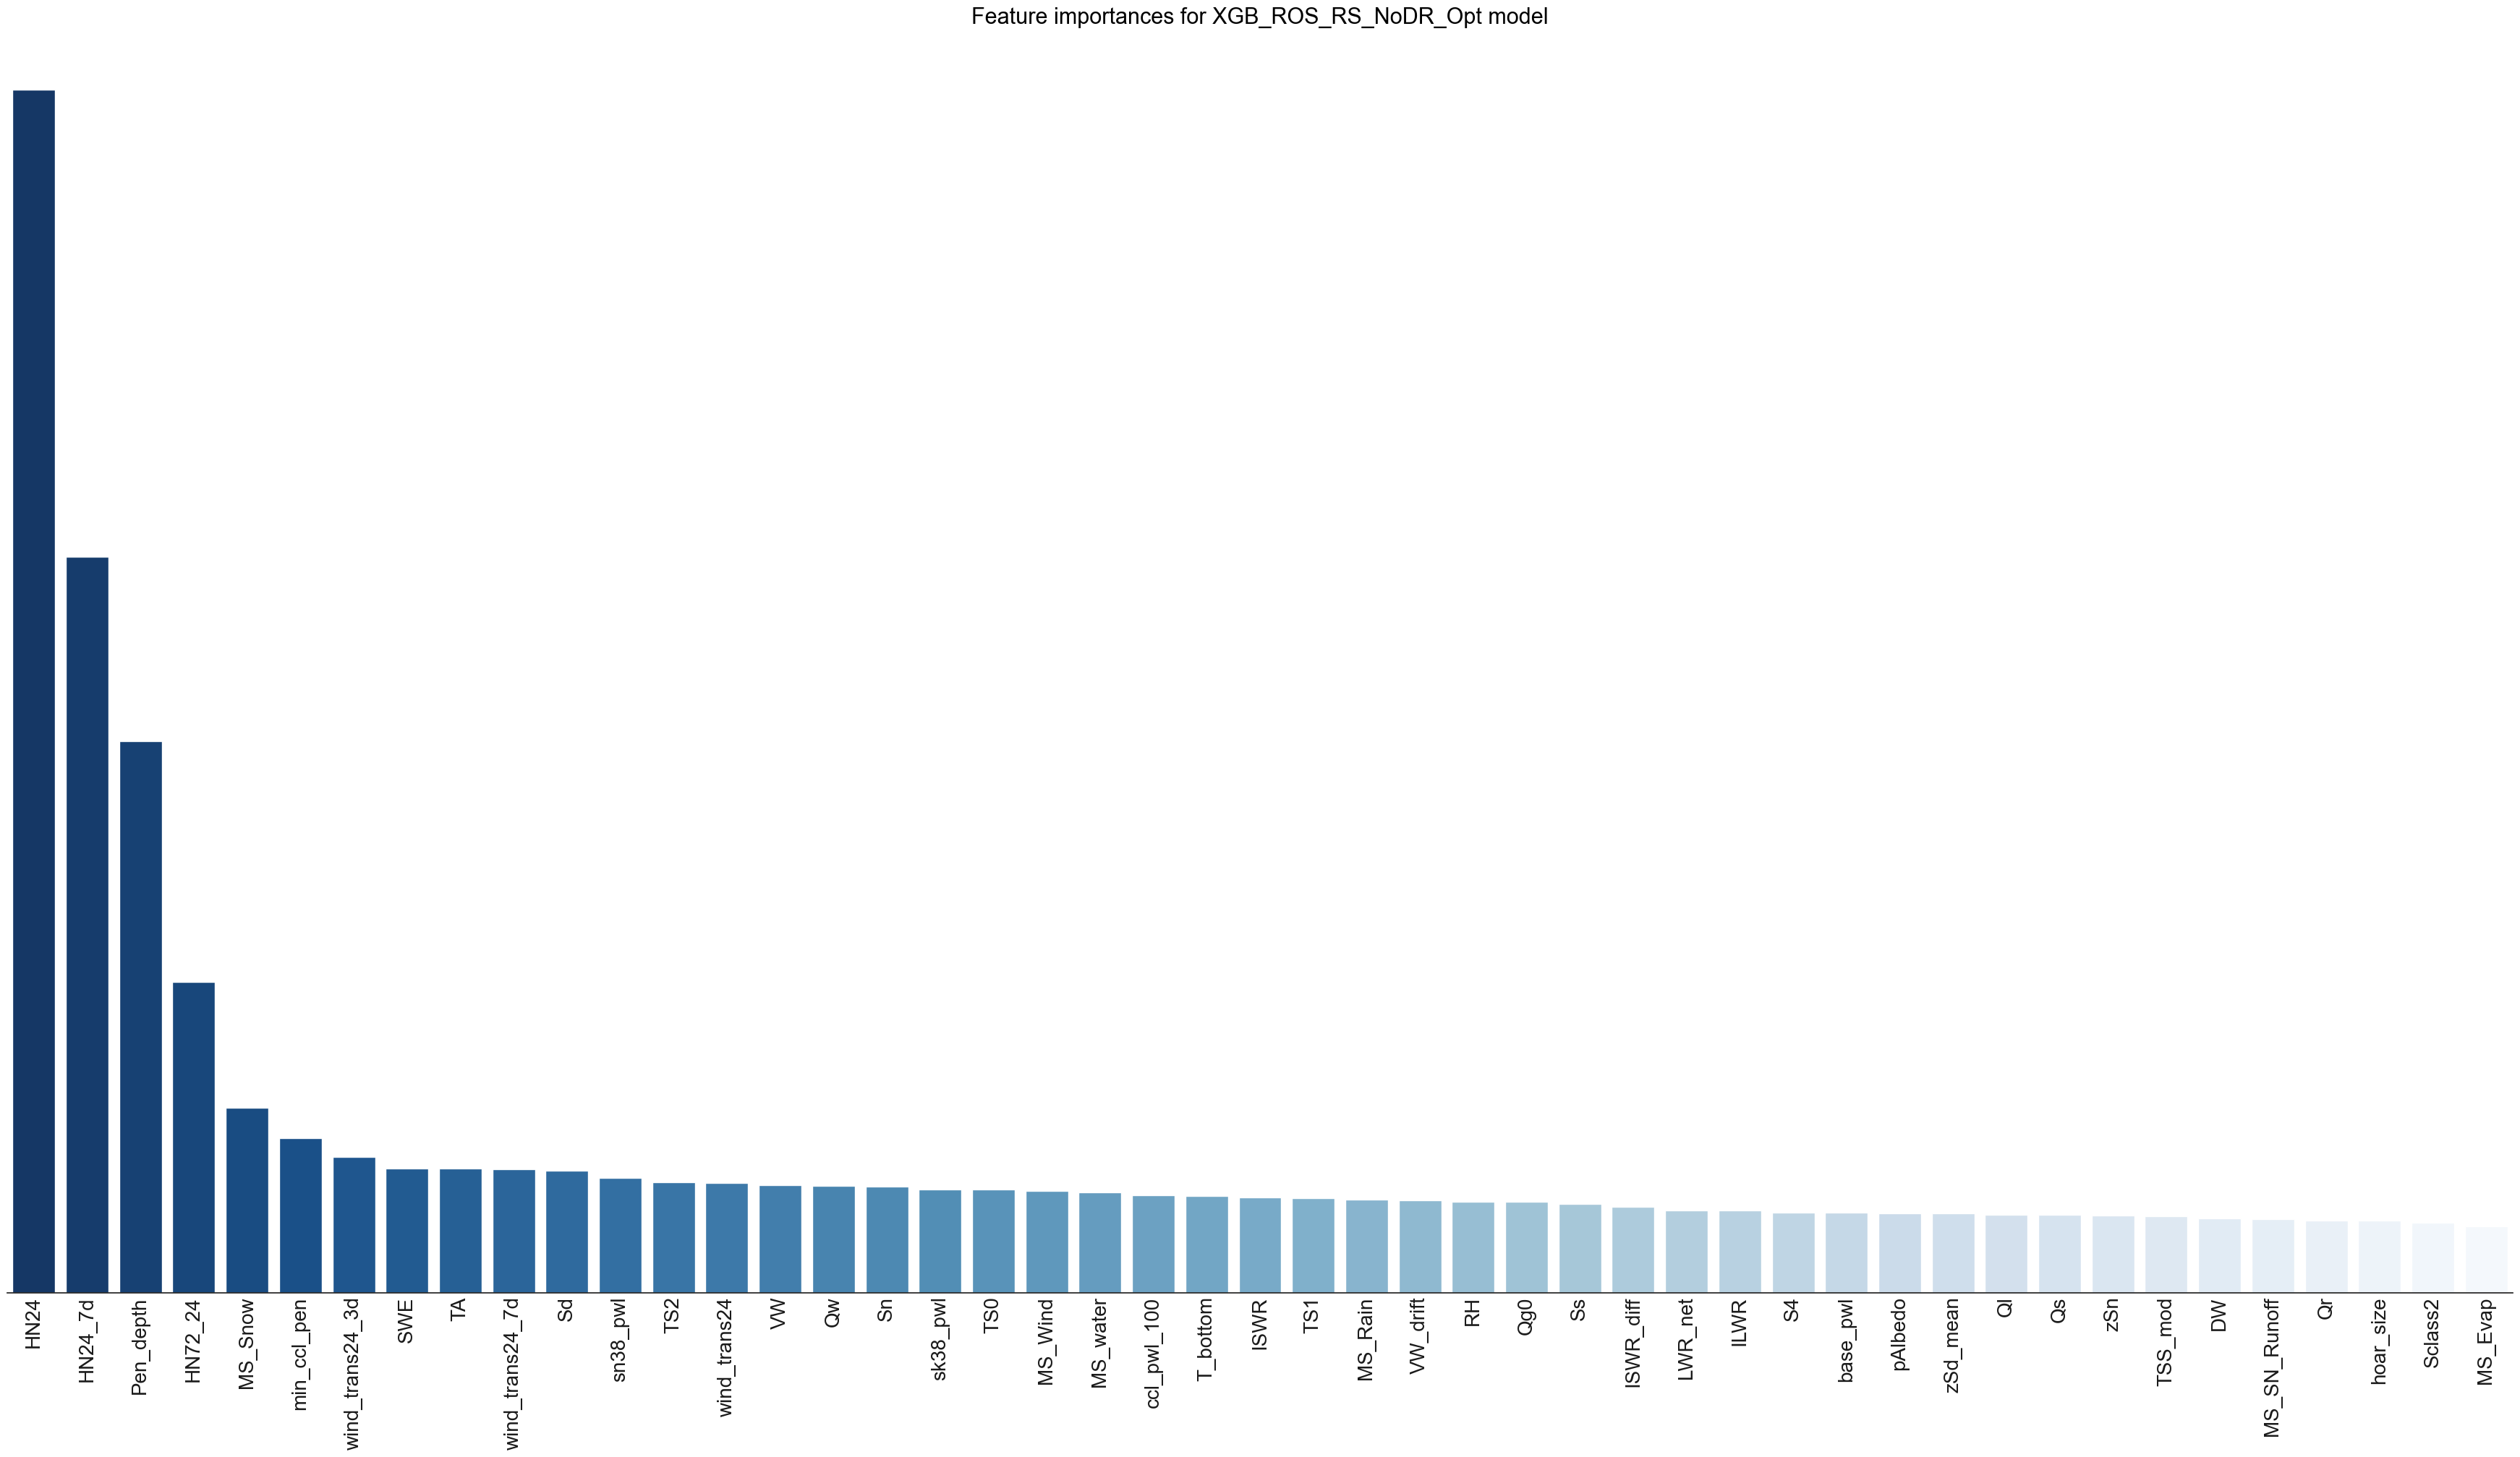

In [ ]:
# Retrain the model with selected features
model = clone(pipelines['XGB_ROS_RS_NoDR'])
model.set_params(**params)
model.fit(X_train[features_save], y_train)

# Plotting feature importances
importances = list(model.named_steps["classifier"].feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(list(X_train[features_save]), importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
RF1, RF1_imp = sorted_features,  sorted_importances 
palette = (sns.color_palette("Blues", len(RF1)))
palette.reverse()
title_font = {'size':'22', 'color':'black'}
sns.set(style = "white", palette = "muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(35, 20), sharex=False)
sns.despine(left=True)
sns.barplot(x=RF1, y=RF1_imp, hue=RF1, palette=palette, legend=False)
for ax in f.axes:
    ax.tick_params(labelrotation = 90)
    ax.tick_params(direction ='in', length = 6, width =0.5, colors = 'k', grid_color = 'k', grid_alpha = 0.5, labelsize = '20')
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.title(f"Feature importances for {model_name} model", fontdict=title_font)
plt.savefig(os.path.join(PLOTS_DIR, "feature_importances.png"))
plt.show()

### 3.6.2 Select a subset of features

Now we select a subset of features from the set just found. To do this, we first find the **minimum number of features** that can statistically achieve the same performance as the full set of features, using `cross_val_score`:

In [ ]:
N_FOLDS_OUT = 15
outer_splits = get_expanding_splits(groups, train_seasons, N_FOLDS_OUT)
scores_dict = {name: [] for name in list(range(10, len(features_save) + 1, 10)) + [len(features_save)]}

# Compute the "full" scores on all already filtered features
print(f"Testing on {len(features_save)} features...")
pipe = clone(model)
pipe.set_params(**params)
pipe.fit(X_train[features_save], y_train)
scores = cross_val_score(
    pipe, X_train, y_train,
    cv=outer_splits,
    scoring='f1_macro',
    n_jobs=-1
)
scores_dict[len(features_save)] = scores
print(f" - Mean full score: {np.mean(scores_dict[len(features_save)])}")

# Increasing iteration for k features
ALPHA = 0.05
selected_feats = None
for l in range(10, len(features_save) + 1, 10):
    feats_l = features_save[:l]
    print(f"Testing on {l} features...")
    pipe = clone(model)
    pipe.set_params(**params)
    pipe.fit(X_train[feats_l], y_train)
    scores = cross_val_score(
        pipe, X_train[feats_l], y_train,
        cv=outer_splits,
        scoring='f1_macro',
        n_jobs=-1
    )
    scores_dict[l] = scores
    print(f" - Mean score: {np.mean(scores_dict[l])}")
    # Use Wilcoxon signed-rank test to compare with the full set
    stat, pval = wilcoxon(scores_dict[len(features_save)], scores_dict[l], alternative="greater")
    if pval > ALPHA:
        print(f" - No significant difference with {l} features (p={pval:.4f}), stopping search.")
        selected_feats = feats_l
        break
    else:
        print(f" - Significant difference with {l} features (p={pval:.4f}), continuing search.")
   
# If no features were selected, use the full set
if selected_feats is None:
    selected_feats = features_save
print(f"Selected features: {len(selected_feats)}")

Testing on 47 features...
 - Mean full score: 0.6140645895624769
Testing on 10 features...
 - Mean score: 0.5871358524920266
 - Significant difference with 10 features (p=0.0034), continuing search.
Testing on 20 features...
 - Mean score: 0.6121907966983784
 - No significant difference with 20 features (p=0.1947), stopping search.
Selected features: 20


Then, we **find the subset of features** of the selected size using `Recursive Feature Elimination`:

In [386]:
from sklearn.feature_selection import RFE

# RFE for feature selection
orig_clf = model.named_steps['classifier']
rfe = RFE(
    estimator=clone(orig_clf),
    step=1,
    n_features_to_select=len(selected_feats),
)
new_steps = model.steps[:-1] + [
    ('rfe', rfe),
    ('classifier', orig_clf)
]
opt_model = clone(ImbPipeline(new_steps))
opt_model.set_params(**params)
opt_model.fit(X_train[features_save], y_train)
print(f"RFE selected {opt_model[-2].support_.sum()} features out of {len(features_save)}:")

# Collect RFE results
d = {'Feature': [], 'Support': [], 'Ranking': []}
feat_RFE = pd.DataFrame(data=d)
for i in range(X_train[features_save].shape[1]):
    df = [X_train[features_save].columns[i], opt_model[-2].support_[i], opt_model[-2].ranking_[i]]
    feat_RFE.loc[len(feat_RFE)] = df
feat_select = feat_RFE.loc[feat_RFE['Support'] == 1, 'Feature']
print(list(feat_select))

# Add the feature selector to the pipeline
col_selector = ColumnTransformer(
    [('selector', 'passthrough', feat_select)],
    remainder='drop'  
)
new_steps = [
    ('column_select', col_selector)
] + model.steps
model_opt = clone(ImbPipeline(new_steps))
model_opt

RFE selected 20 features out of 47:
['HN24', 'HN24_7d', 'Pen_depth', 'HN72_24', 'MS_Snow', 'min_ccl_pen', 'wind_trans24_3d', 'SWE', 'TA', 'wind_trans24_7d', 'Sd', 'sn38_pwl', 'Qw', 'wind_trans24', 'TS2', 'Sn', 'VW', 'sk38_pwl', 'MS_Wind', 'TS0']


Pipeline(steps=[('column_select',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  0                HN24
1             HN24_7d
2           Pen_depth
3             HN72_24
4             MS_Snow
5         min_ccl_pen
6     wind_trans24_3d
7                 SWE
8                  TA
9     wind_trans24_7d
10                 Sd
11           sn38_pwl
13                 Qw
14       wind_trans24
15                TS2
16                 Sn
18                 VW
20           sk38_pwl
21            MS_Wind
22                TS0
Name: Feature, dtype: object)])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('scaler', RobustScaler(...
                               gamma=np.float64(0.06983140212909127),
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.02721522256123595),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=463,
                               n_jobs=None, ...))])

### 3.6.3 Hyperparameter re-tuning

We slightly change the hyperparameter search space, and we re-tune the model using `RandomizedSearchCV` with the new search space:

In [396]:
import numpy as np

def make_local_grid(best_params, 
                    int_rel_step=0.2,   # passo relativo per interi > 5
                    int_abs_step=1,     # passo assoluto (per interi ≤ 5)
                    float_rel_step=0.2  # passo relativo per float
                   ):         
    new_grid = {}
    for k, v in best_params.items():
        # BOOL -> no variation
        if isinstance(v, bool):
            new_grid[k] = [v]
        # INTEGER
        elif isinstance(v, int):
            if v <= 5:
                delta = int_abs_step
            else:
                delta = max(1, int(v * int_rel_step))
            new_grid[k] = sorted({max(2, v - delta), v, v + delta})
        # FLOAT or numpy float
        elif isinstance(v, float) or isinstance(v, np.floating):
            delta = float_rel_step
            v_float = float(v)
            vals = [v_float - v_float * delta, v_float, v_float + v_float * delta]
            # Special handling for colsample_bytree: must be in (0, 1]
            if k == "classifier__colsample_bytree":
                vals = [min(max(0.01, x), 1.0) for x in vals]
            new_grid[k] = sorted(set(vals))
        # CATEGORICAL / STRING -> no variation
        else:
            new_grid[k] = [v]
    return new_grid

model_opt_name = model_name + '_Opt'
grid = make_local_grid(params)
print(f"Local grid for {model_opt_name}:")
for k, v in grid.items():
    print(f"{k}: {v}")

Local grid for XGB_ROS_RS_NoDR_Opt:
classifier__class_weight: [None]
classifier__colsample_bytree: [0.7916017660292669, 0.9895022075365837, 1.0]
classifier__gamma: [0.05586512170327301, 0.06983140212909127, 0.08379768255490952]
classifier__learning_rate: [0.02177217804898876, 0.02721522256123595, 0.03265826707348314]
classifier__max_depth: [7, 8, 9]
classifier__min_child_weight: [2, 3, 4]
classifier__n_estimators: [371, 463, 555]
classifier__reg_alpha: [0.4113875507308893, 0.5142344384136116, 0.6170813260963339]
classifier__reg_lambda: [2.6957266203585357, 3.36965827544817, 4.043589930537804]
classifier__subsample: [0.49486413207039925, 0.6185801650879991, 0.7422961981055989]
sampler__sampling_strategy: ['auto']


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
import pandas as pd

N_ITER = 100
N_SPLITS = 5
inner_splits = get_expanding_splits(groups, train_seasons, N_SPLITS)

print(f"Computing scores with previously tuned parameters...")
scores = cross_val_score(
    model_opt.set_params(**params), X_train, y_train,
    cv=inner_splits,
    scoring='f1_macro',
    n_jobs=-1
)
print(f" - Mean score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

print(f"Tuning pipeline: {model_opt_name}")
# RandomizedSearchCV on training data only
search = RandomizedSearchCV(
    estimator=model_opt,
    param_distributions=grid,
    cv=inner_splits,            # expanding-window CV on X_train
    scoring="f1_macro",       # optimize f1_macro
    n_iter=N_ITER,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)
print(f" - Best CV score: {search.best_score_:.4f}")
print(f" - Best parameters: {search.best_params_}\n")

# Collect tuning summary
results = {
    "pipeline": model_opt_name,
    "best_cv_score": search.best_score_ if search.best_score_ > np.mean(scores) else np.mean(scores),
    "best_params": search.best_params_ if search.best_score_ > np.mean(scores) else params,
}

best_params = search.best_params_
tuning_df = pd.DataFrame([results])
tuning_df.to_csv(os.path.join(CSV_DIR, 'tuning_summary_opt.csv'), index=False)

Computing scores with previously tuned parameters...
 - Mean score: 0.5939 ± 0.0515
Tuning pipeline: XGB_ROS_RS_NoDR_Opt
 - Best CV score: 0.5997
 - Best parameters: {'sampler__sampling_strategy': 'auto', 'classifier__subsample': 0.49486413207039925, 'classifier__reg_lambda': 3.36965827544817, 'classifier__reg_alpha': 0.4113875507308893, 'classifier__n_estimators': 371, 'classifier__min_child_weight': 2, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.02177217804898876, 'classifier__gamma': 0.06983140212909127, 'classifier__colsample_bytree': 0.7916017660292669, 'classifier__class_weight': None}



### 3.6.4 Statistical comparison

Collecting more observations:

In [ ]:
N_FOLDS_OUT = 15
outer_splits = get_expanding_splits(groups, train_seasons, N_FOLDS_OUT)

# Collect CV scores via cross_val_score
scores_dict = {}
pipe = clone(model_opt)
pipe.set_params(**search.best_params_)
pipe.fit(X_train, y_train)
scores = cross_val_score(
    pipe, X_train, y_train,
    cv=outer_splits,
    scoring='f1_macro',
    n_jobs=-1
)
scores_dict[model_opt_name] = scores

# Results summary
opt_scores_df = pd.DataFrame(scores_dict)
pd.DataFrame({
    'mean_f1': opt_scores_df.mean(),
    'std_f1': opt_scores_df.std(),
    'median_f1': opt_scores_df.median()
})

,mean_f1,std_f1,median_f1
XGB_ROS_RS_NoDR_Opt,0.625891,0.058171,0.626151


Now we compare the new model with the previous one (and the paper's one as reference):

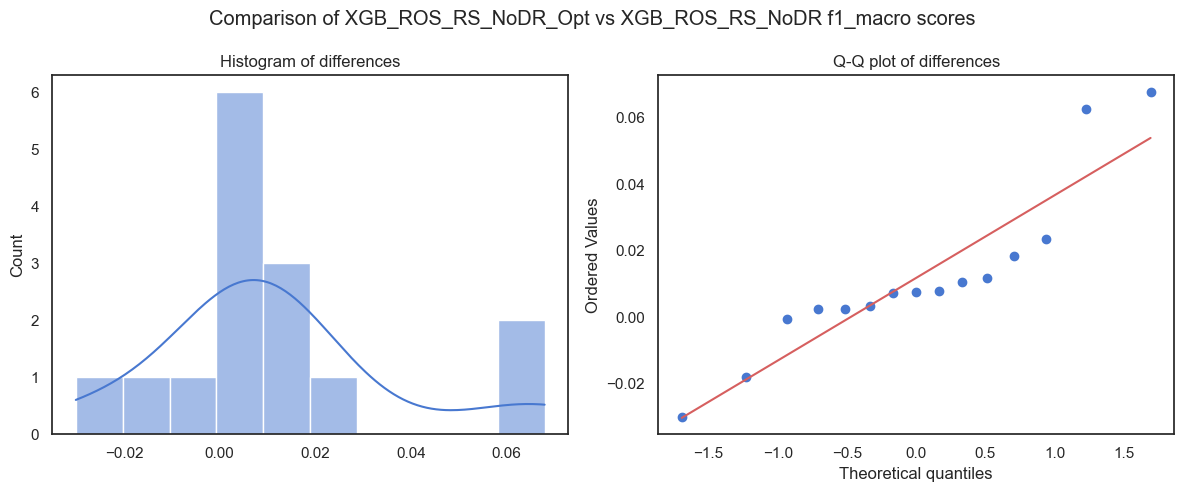

Comparing XGB_ROS_RS_NoDR_Opt with XGB_ROS_RS_NoDR...
Shapiro-Wilk test: W=0.861, p=0.025
Differences are not normal => Wilcoxon signed-rank test
W=24.000, p=0.041
Significant result (p<0.05): optimized model performs better.


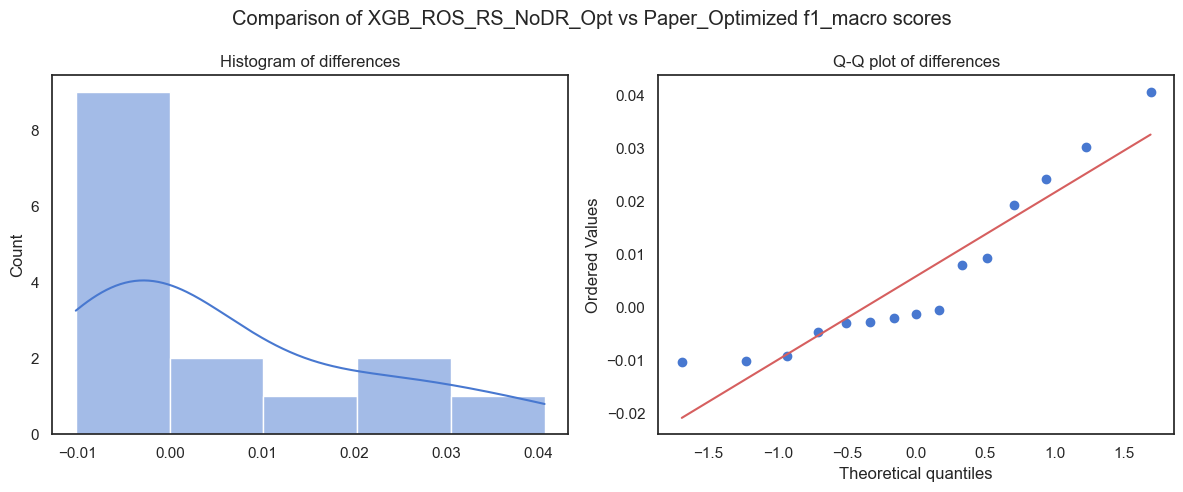

Comparing XGB_ROS_RS_NoDR_Opt with Paper_Optimized...
Shapiro-Wilk test: W=0.868, p=0.031
Differences are not normal => Wilcoxon signed-rank test
W=50.000, p=0.599
No significant difference between models (p>0.05).


In [462]:
import scipy.stats as stats

ALPHA = 0.05
for model_name in ['XGB_ROS_RS_NoDR', 'Paper_Optimized']:
    models_scores = pd.DataFrame({
        model_opt_name: opt_scores_df.squeeze(),
        model_name: scores_df[model_name].values
    })
    opt_scores = models_scores[model_opt_name]
    base_scores = models_scores[model_name]

    # Histogram and Q-Q plot of differences
    differences = opt_scores - base_scores
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(differences, kde=True, ax=axes[0])
    axes[0].set_title("Histogram of differences")
    stats.probplot(differences, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q plot of differences")
    plt.suptitle(f"Comparison of {model_opt_name} vs {model_name} f1_macro scores")
    plt.tight_layout()
    plt.savefig(os.path.join("../results/training/imgs", f"comparison_{model_opt_name}_vs_{model_name}.png"))
    plt.show()

    # 1. Shapiro–Wilk test for normality of differences
    print(f"Comparing {model_opt_name} with {model_name}...")
    shapiro_stat, shapiro_p = stats.shapiro(differences)
    print(f"Shapiro-Wilk test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}")

    # 2. If differences are normally distributed (p > ALPHA), use paired t-test
    if shapiro_p > ALPHA:
        t_stat, t_p = stats.ttest_rel(opt_scores, base_scores)
        print("Differences are normal => Paired t-test")
        print(f"t={t_stat:.3f}, p={t_p:.3f}")
        if t_p < ALPHA:
            if differences.mean() > 0:
                print(f"Significant result (p<{ALPHA}): optimized model performs better.")
            else:
                print(f"Significant result (p<{ALPHA}): base model performs better.")
        else:
            print(f"No significant difference between models (p>{ALPHA}).")
    else:
        # 3. Otherwise, use non-parametric Wilcoxon signed-rank test
        w_stat, w_p = stats.wilcoxon(opt_scores, base_scores)
        print("Differences are not normal => Wilcoxon signed-rank test")
        print(f"W={w_stat:.3f}, p={w_p:.3f}")
        if w_p < ALPHA:
            if differences.mean() > 0:
                print(f"Significant result (p<{ALPHA}): optimized model performs better.")
            else:
                print(f"Significant result (p<{ALPHA}): base model performs better.")
        else:
            print(f"No significant difference between models (p>{ALPHA}).")

### 3.6.5 Final evaluation using Hold-out Set

Finally, we evaluate the optimized model on the hold-out set to see how the performance has improved.

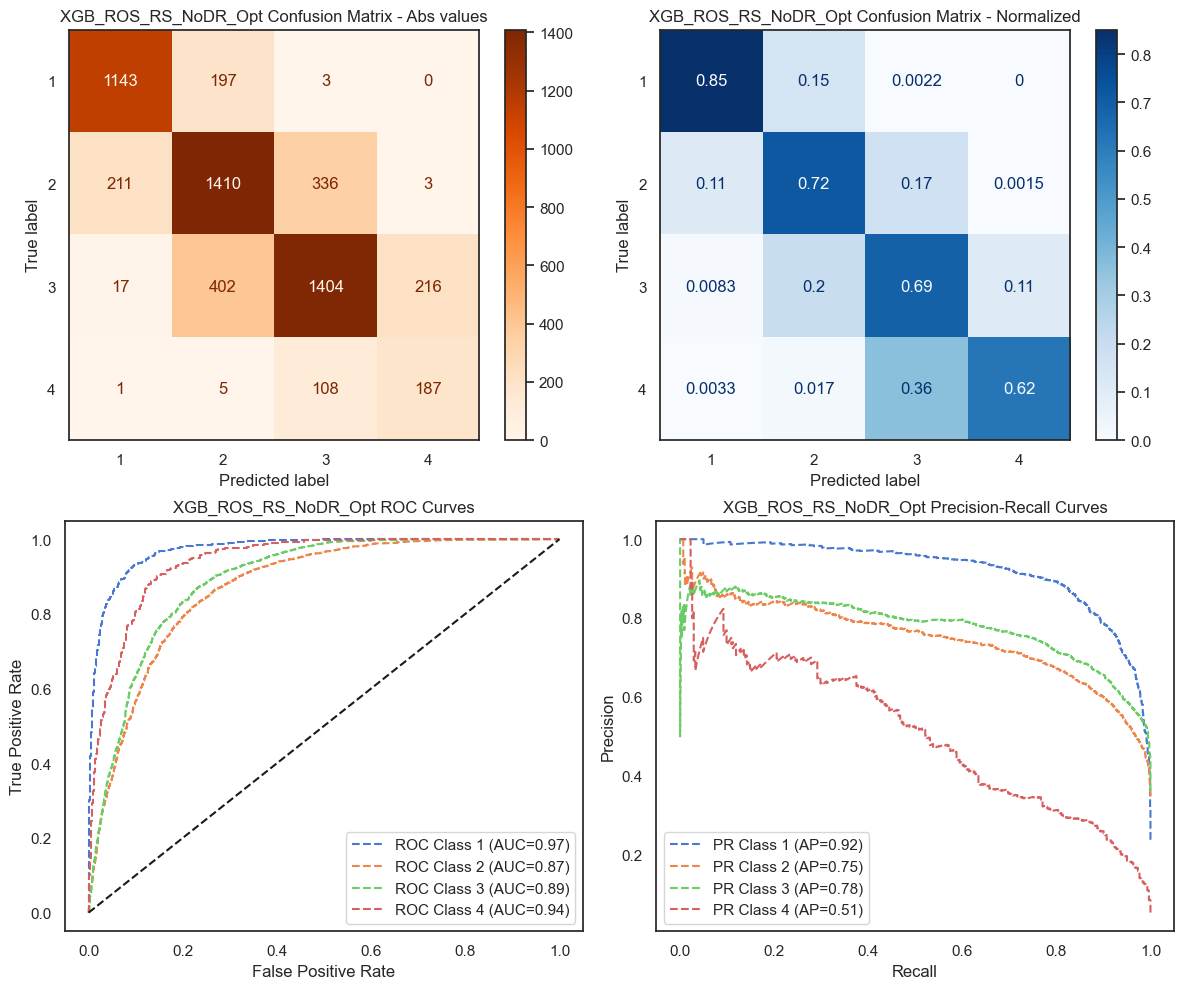

Final metrics for the optimized model:


,accuracy,f1_macro,balanced_accuracy,mcc
XGB_ROS_RS_NoDR_Opt,0.734361,0.700612,0.720076,0.618952


In [432]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
classes = np.unique(y_test)
y_bin = label_binarize(y_test, classes=classes)

model_name = model_opt_name
model = clone(model_opt)
model.set_params(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_macro': f1_score(y_test, y_pred, average='macro'),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'mcc': matthews_corrcoef(y_test, y_pred)
}
metrics_df = pd.DataFrame(metrics, index=[model_name])
metrics_df.to_csv(os.path.join(CSV_DIR, 'best_model_opt_metrics.csv'))

# Confusion matrix (absolute values)
ax_cm = axes[0, 0]
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[1, 2, 3, 4],
    cmap=plt.cm.Oranges,
    ax=ax_cm
)
ax_cm.set_title(f"{model_name} Confusion Matrix - Abs values")

# Confusion matrix (Normalized)
ax_cm_norm = axes[0, 1]
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=[1, 2, 3, 4],
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax_cm_norm
)
ax_cm_norm.set_title(f"{model_name} Confusion Matrix - Normalized")

# ROC curves (one-vs-rest)
ax_roc = axes[1, 0]
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, linestyle='--', label=f"ROC Class {cls + 1} (AUC={roc_auc:.2f})")
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_title(f"{model_name} ROC Curves")
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend(loc='lower right')

# Precision-Recall curves (one-vs-rest)
ax_pr = axes[1, 1]
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_bin[:, i], y_prob[:, i])
    ax_pr.plot(recall, precision, linestyle='--', label=f"PR Class {cls + 1} (AP={ap:.2f})")
ax_pr.set_title(f"{model_name} Precision-Recall Curves")
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.legend(loc='lower left')

# Figures
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "best_model_opt_focus.png"))
plt.show()

# Show final metrics
print("Final metrics for the optimized model:")
metrics_df

Although the ROC and precision-recall curves are virtually unchanged—indicating that the model’s ranking ability remains the same—the optimized pipeline clearly **improves its ability to identify class 4**, as evidenced by the stronger true-4 recall in the confusion matrix. This focused gain translates into a noticeable **uplift in macro F1** (now 0.7006) **and balanced accuracy** (0.7201), while the overall accuracy (0.7344) and MCC (0.6190) remain essentially constant.


### 3.6.6 Saving the optimized model

Finally, we save the optimized model:

In [438]:
import joblib

# Save the optimized model
model = clone(model_opt)
model.set_params(**best_params)
model.fit(X, y)
joblib.dump(model, os.path.join(MODELS_DIR, f"{model_opt_name}.pkl"))

['..\\models\\rf\\XGB_ROS_RS_NoDR_Opt.pkl']